In [8]:
ls ../tests/data/test_data

db.fsa          primer.json     primers/        query.json      templates.json
genbank/        primerdb.fsa    query.fsa       seqio_plasmids/


In [20]:
from dasi import logger
from dasi import cost
import hashlib
from glob import glob
import os
def hashfiles(files, hash="sha1", hashfunc=None):
    if not hashfunc:

        def hashfunc(string):
            return getattr(hashlib, hash)(string.encode("utf-8")).hexdigest()

    contents = ""
    sorted_path = sorted(files)
    for file in sorted_path:
        with open(file, "r") as f:
            contents += hashfunc(f.read())
    return hashfunc(contents)


def cost_module_checksum():
    cost_dir = os.path.dirname(cost.__file__)
    cost_files = sorted(
        glob(os.path.join(cost_dir, "*.py")) + glob(os.path.join(cost_dir, "*.json"))
    )
    return hashfiles(cost_files)


def cached(path, save_func, load_func, checksum_path, logger=None):
    different_checksum = True
    checksum = cost_module_checksum()
    if os.path.isfile(checksum_path):
        with open(checksum_path, "r") as f:
            stored_checksum = f.read().strip()
            if stored_checksum == checksum:
                different_checksum = False
            if logger:
                logger.debug("Stored checksum: {}".format(stored_checksum))
    if logger:
        logger.debug("Checksum: {}".format(checksum))
    if different_checksum or not os.path.isfile(path):
        if logger:
            logger.debug("Using default params")
        model = save_func(path)
        with open(checksum_path, "w") as f:
            f.write(checksum)
        stat = os.stat(path)
        if logger:
            logger.debug("Wrote {} bytes".format(stat.st_size))
    else:
        if logger:
            logger.debug("Loading {}".format(path))
        stat = os.stat(path)
        if logger:
            logger.debug("Loaded {} bytes".format(stat.st_size))
        model = load_func(path)
    return model

def cached_span_cost(cost_filepath, cost_checksum_filepath):
    """This will check the checksum of the cost module against the last
    checksum. If checksums are the same, the span cost will be loaded. Else,
    span_cost will be created from default parameters and saved with the cost
    module's checksum.

    :param cost_filepath: path of the span_cost
    :param cost_checksum_filepath: path of the checksum
    :return: SpanCost
    """

    def load_span_cost(path):
        span_cost = cost.SpanCost.load(path)
        return span_cost

    def save_span_cost(path):
        span_cost = cost.SpanCost.open()
        span_cost.dump(path)
        return span_cost

    return cached(
        cost_filepath,
        load_func=load_span_cost,
        save_func=save_span_cost,
        checksum_path=cost_checksum_filepath,
        logger=logger,
    )

cached_span_cost('span_cost.b', 'cost_checksum')

/Users/justinvrana/Documents/GitHub/DASi-DNA-Design/dasi/cost/__init__.py:374: RuntimeWarning: divide by zero encountered in true_divide
  cost = material_cost / eff
/Users/justinvrana/Documents/GitHub/DASi-DNA-Design/dasi/cost/__init__.py:374: RuntimeWarning: invalid value encountered in true_divide
  cost = material_cost / eff
/Users/justinvrana/Documents/GitHub/DASi-DNA-Design/dasi/cost/__init__.py:524: RuntimeWarning: divide by zero encountered in true_divide
  syn_total_cost = (syn_material_cost + syn_time_cost[np.newaxis, ...]) / syn_eff
/Users/justinvrana/Documents/GitHub/DASi-DNA-Design/dasi/cost/__init__.py:524: RuntimeWarning: invalid value encountered in true_divide
  syn_total_cost = (syn_material_cost + syn_time_cost[np.newaxis, ...]) / syn_eff


In [76]:
from dasi import LibraryDesign
from pyblast.utils import make_linear, make_circular, load_fasta_glob, load_genbank_glob
import warnings
from Bio import BiopythonParserWarning
from matplotlib import MatplotlibDeprecationWarning
from dasi.constants import Constants

warnings.simplefilter("ignore", BiopythonParserWarning)
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)

templates = make_circular(load_genbank_glob("../tests/data/test_data/genbank/templates/*.gb"))
registry = make_circular(load_genbank_glob("../tests/data/test_data/genbank/benchling_registry/*.gb"))
primers = make_linear(load_fasta_glob('../tests/data/test_data/primers/primers.fasta'))
queries = make_circular(load_genbank_glob('../tests/data/test_data/genbank/designs/*.gb'))

assert templates
assert registry
assert primers
assert queries

design = LibraryDesign()
design.add_templates(registry)
design.add_primers(primers)
design.add_queries(queries)

blast.quick_blastn()
results = blast.get_perfect()
results = [r for r in results if r['subject']['origin_key'] != r['query']['origin_key']]

design.container_factory.seqdb.update(blast.seq_db.records)
design.container_factory.load_blast_json(results, Constants.SHARED_FRAGMENT)

In [154]:
from dasi.models import AlignmentContainer
from dasi.utils import sort_with_keys
from dasi.utils import Region

def overlapping_groups(group_list_a, group_list_b):
    group_sort, group_keys = sort_with_keys(
            group_list_b, key=lambda x: x.query_region.a
        )
    tuples = []
    for group_a in group_list_a:
        alignments = []
        overlapping = AlignmentContainer.filter_alignments_by_span(
                group_sort,
                group_a.query_region,
                key=lambda p: p.query_region.a,
                end_inclusive=False,
            )
        if group_a in overlapping:
            overlapping.remove(group_a)
        tuples.append((group_a, overlapping))
    return tuples


all_groups = []
for container in design.container_factory.containers().values():
    all_groups += container.get_groups_by_types(Constants.SHARED_FRAGMENT)
    
grouped_by_qk = {}
for g in all_groups:
    grouped_by_qk.setdefault(g.query_key, list())
    grouped_by_qk[g.query_key].append(g)

for qk, groups in list(grouped_by_qk.items())[:]:
    overlapping = overlapping_groups(groups, groups)
    starts = []
    ends = []
    for g, glist in overlapping:
        print("first group: {}".format(g.query_region))
        starts.append(g.query_region.start)
        ends.append(g.query_region.end)
        for _g in glist:
            starts.append(_g.query_region.start)
            ends.append(_g.query_region.end)
    print(len(starts))
    print(len(ends))
#     overlapping = overlapping_groups(groups, groups)
#     print(len(overlapping))

first group: <Region 3333 5721 (5721) context_len=6915 len=2388 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 3333 5567 (5567) context_len=6915 len=2234 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 5567 5721 (5721) context_len=6915 len=154 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 5719 5750 (5750) context_len=6915 len=31 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 3341 3807 (3807) context_len=6915 len=466 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 5196 5472 (5472) context_len=6915 len=276 cyclic=True direction=1 index=0, nwraps=0>
15
15
first group: <Region 3538 4748 (4748) context_len=4779 len=1210 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 2296 3506 (3506) context_len=4779 len=1210 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 2296 2930 (2930) context_len=4779 len=634 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 4172 4779 (4779)

first group: <Region 3884 3928 (3928) context_len=6110 len=44 cyclic=True direction=1 index=0, nwraps=0>
92
92
first group: <Region 4355 1091 (9227) context_len=8136 len=4872 cyclic=True direction=1 index=0, nwraps=1>
first group: <Region 4355 8136 (8136) context_len=8136 len=3781 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 0 1091 (1091) context_len=8136 len=1091 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 755 938 (938) context_len=8136 len=183 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 5235 5418 (5418) context_len=8136 len=183 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 5111 5188 (5188) context_len=8136 len=77 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 4954 5031 (5031) context_len=8136 len=77 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 3571 3605 (3605) context_len=8136 len=34 cyclic=True direction=1 index=0, nwraps=0>
first group: <Region 4355 3605 (11741) context_

{'92c252cf-facc-432b-b842-06e1e98e7d72': [(7764, 7947), (4108, 4291)], '2bf55dde-2d75-4e56-b6ce-eb09479d461e': [(858, 1041), (4514, 4697)], '79d6418c-3a64-497b-b675-4f6bb9f468d1': [(755, 938), (5235, 5418)]}
{'92c252cf-facc-432b-b842-06e1e98e7d72': [(3827, 3904), (3984, 4061)], '79d6418c-3a64-497b-b675-4f6bb9f468d1': [(5111, 5188), (4954, 5031)], '116ecdc2-c831-4f51-99cb-ee72bfa13859': [(4505, 4582)], '2bf55dde-2d75-4e56-b6ce-eb09479d461e': [(734, 811), (577, 654)]}
{'116ecdc2-c831-4f51-99cb-ee72bfa13859': [(335, 1545), (1577, 2787)], '357e26c4-5158-446f-9850-85f56a31b9ad': [(4230, 609), (2988, 4198)], '355be3b3-cd61-40ca-aedd-f79c0aa00ace': [(2296, 3506), (3538, 4748)], '9a287ad0-98ca-4883-a5e6-6e8f27c83fe3': [(2903, 4113), (4145, 576)], 'd62d19c0-1504-4259-b757-873763d1d2a9': [(2296, 3506), (3538, 4748)]}


[[<Alignment FRAGMENT_SHARED_WITH_OTHER_QUERIES <Region 7009 8100 (8100) context_len=8100 len=1091 cyclic=True direction=1 index=0, nwraps=0> <Region 0 1091 (1091) context_len=8136 len=1091 cyclic=True direction=1 index=0, nwraps=0>>],
 [<Alignment FRAGMENT_SHARED_WITH_OTHER_QUERIES <Region 3228 8100 (8100) context_len=8100 len=4872 cyclic=True direction=1 index=0, nwraps=0> <Region 4355 1091 (9227) context_len=8136 len=4872 cyclic=True direction=1 index=0, nwraps=1>>],
 [<Alignment FRAGMENT_SHARED_WITH_OTHER_QUERIES <Region 4355 5055 (5055) context_len=8136 len=700 cyclic=True direction=1 index=0, nwraps=0> <Region 3906 4606 (4606) context_len=6110 len=700 cyclic=True direction=1 index=0, nwraps=0>>],
 [<Alignment FRAGMENT_SHARED_WITH_OTHER_QUERIES <Region 2514 3928 (3928) context_len=8100 len=1414 cyclic=True direction=1 index=0, nwraps=0> <Region 3192 4606 (4606) context_len=6110 len=1414 cyclic=True direction=1 index=0, nwraps=0>>],
 [<Alignment FRAGMENT_SHARED_WITH_OTHER_QUERIES <

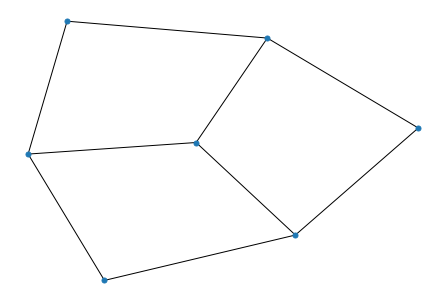

In [212]:
from copy import deepcopy

def to_undirected(graph):
    """.to_undirected is implemented in networkx out of the box, however, it
    suffers from occational infinite recursion errors during the deepcopy phase
    of the method (unknown as to why)."""
    undirected = nx.Graph()
    copied = deepcopy(graph)
    for n in copied.nodes:
        ndata = copied.nodes[n]
        undirected.add_node(n, **ndata)
    for n1, n2 in copied.edges:
        edata = copied.edges[n1, n2]
        undirected.add_edge(n1, n2, **edata)
    return undirected

def get_subgraphs(graph):
    """Get independent subgraphs."""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs


interaction_graph = nx.Graph()

for g in all_groups:
    for a in g.alignments:
        n1 = (a.query_key, a.query_region.a, a.query_region.b)
        n2 = (a.subject_key, a.subject_region.a, a.subject_region.b)
        interaction_graph.add_edge(n1, n2, alignment=a)
graphs = sorted(get_subgraphs(interaction_graph), key=lambda x: x.number_of_nodes())

graph = graphs[-2]

def has_repeats(g):
    """Check if the interaction graph has a repeated DNA sequence"""
    grouped_by_key = {}
    for n in g.nodes:
        grouped_by_key.setdefault(n[0], list())
        grouped_by_key[n[0]].append((n[1], n[2]))
    for k, v in grouped_by_key.items():
        if len(v) > 1:
            print(grouped_by_key)
            return True
    return False
        
nx.draw(graph, node_size=25)
clusters = []

for g in graphs:
    if not has_repeats(g):
        alignments = []
        for n1, n2, edata in g.edges(data=True):
            alignments.append(edata['alignment'])
        clusters.append(alignments)




In [195]:
design.seqdb['2bf55dde-2d75-4e56-b6ce-eb09479d461e'][577:654]

SeqRecord(seq=Seq('GGTACCTTTAAGACCAATGACTTACAAGGCAGCTGTAGATCTTAGCCACTTTTT...AAG', IUPACAmbiguousDNA()), id='pLKO-pEF1a-FRT-tdTomato', name='pLKO-pEF1a-FRT-tdTomato', description='', dbxrefs=[])

In [196]:
design.seqdb['2bf55dde-2d75-4e56-b6ce-eb09479d461e'][734:811]

SeqRecord(seq=Seq('GGTACCTTTAAGACCAATGACTTACAAGGCAGCTGTAGATCTTAGCCACTTTTT...AAG', IUPACAmbiguousDNA()), id='pLKO-pEF1a-FRT-tdTomato', name='pLKO-pEF1a-FRT-tdTomato', description='', dbxrefs=[])

In [162]:
all_keys = dict()
for g in all_groups:
    keys = [g.query_key] + g.subject_keys
    keys.sort()
    gkey = tuple(keys)
    all_keys.setdefault(gkey, list())
    all_keys[gkey].append(g)
    
print(len(all_groups))
print(len(all_keys))

all_keys

144
31


{('0d56ede1-b91d-4ac5-91a7-cf3900c2cde1',
  '51320a33-b5c8-424f-b6fd-2062469dbce8'): [<AlignmentGroup <Region 3333 5721 (5721) context_len=6915 len=2388 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 3333 5567 (5567) context_len=6915 len=2234 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 5567 5721 (5721) context_len=6915 len=154 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 5719 5750 (5750) context_len=6915 len=31 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 7174 154 (9562) context_len=9408 len=2388 cyclic=True direction=1 index=0, nwraps=1>>,
  <AlignmentGroup <Region 7174 9408 (9408) context_len=9408 len=2234 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 0 154 (154) context_len=9408 len=154 cyclic=True direction=1 index=0, nwraps=0>>,
  <AlignmentGroup <Region 724 755 (755) context_len=9408 len=31 cyclic=True direction=1 index=0, nwraps=0>>],
 ('51320a33-b5c8-4

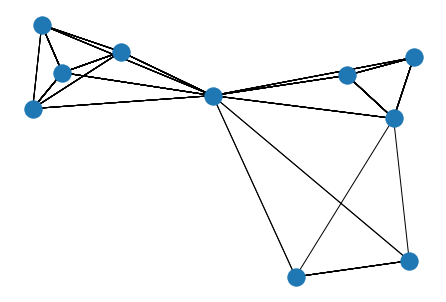

In [72]:
import networkx as nx
%matplotlib inline

blast = design.blast_factory('queries', 'queries')

blast.quick_blastn()
results = blast.get_perfect()
results = [r for r in results if r['subject']['origin_key'] != r['query']['origin_key']]

g = nx.MultiGraph()

edges = []
for r in results:
    sk = r['subject']['origin_key']
    qk = r['query']['origin_key']
    k1 = (qk, (r['query']['start'], r['query']['end']))
    k2 = (sk, (r['subject']['start'], r['subject']['end']))
    keys = sorted([k1, k2])
    edges.append(keys)
    
for n1, n2 in edges:
    g.add_edge(n1[0], n2[0])
    
nx.draw(g)

In [55]:
r

{'query': {'start': 469,
  'end': 2237,
  'bases': 'CCA-CAAAAGGCCAGGAACCGTAAAAAGGCCGCGTTGCTGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAGCATCACAAAAATCGACGCTCAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGGCGTTTCCCCCTGGAAGCTCCCTCGTGCGCTCTCCTGTTCCGACCCTGCCGCTTACCGGATACCTGTCCGCCTTTCTCCCTTCGGGAAGCGTGGCGCTTTCTCATAGCTCACGCTGTAGGTATCTCAGTTCGGTGTAGGTCGTTCGCTCCAAGCTGGGCTGTGTGCACGAACCCCCCGTTCAGCCCGACCGCTGCGCCTTATCCGGTAACTATCGTCTTGAGTCCAACCCGGTAAGACACGACTTATCGCCACTGGCAGCAGCCACTGGTAACAGGATTAGCAGAGCGAGGTATGTAGGCGGTGCTACAGAGTTCTTGAAGTGGTGGCCTAACTACGGCTACACTAGAAGGACAGTATTTGGTATCTGCGCTCTGCTGAAGCCAGTTACCTTCGGAAAAAGAGTTGGTAGCTCTTGATCCGGCAAACAAACCACCGCTGGTAGCGGTGGTTTTTTTGTTTGCAAGCAGCAGATTACGCGCAGAAAAAAAGGATCTCAAGAAGATCCTTTGATCTTTTCTACGGGGTCTGACGCTCAGTGGAACGAAAACTCACGTTAAGGGATTTTGGTCATGAGATTATCAAAAAGGATCTTCACCTAGATCCTTTTAAATTAAAAATGAAGTTTTAAATCAATCTAAAGTATATATGAGTAAACTTGGTCTGACAGTTACCAATGCTTAATCAGTGAGGCACCTATCTCAGCGATCTGTCTATTTCGTTCATCCATAGTTGCCTGACTCCCCGTCGTGTAGATAACTACGATACGGGAGGGCTTACCATCTGGCCCCAGTGCTGCAATGATACCGCGAGA